# Example 00 - The Sig53 Dataset
This notebook walks through an example of how the official Sig53 dataset can be instantiated and analyzed.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [1]:
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.utils.writer import DatasetCreator, DatasetLoader
from torchsig.utils.dataset import SignalDataset
from torchsig.datasets.sig53 import Sig53
from torchsig.datasets import conf
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm
import numpy as np
import os

----
# Generate and Store Sig53
Datasets in TorchSig can either be generated and stored on disk, generated on the fly, or a mixture of the two. Sig53, being a dataset with which performance can be benchmarked, is meant to be generated and stored on disk.

### Generation Function
Sig53 is generated with a synthetic dataset called ```ModulationsDataset``` underneath. We instantiate this dataset with a specific configuration file, use a PyTorch ```DataLoader``` to generate samples in parallel, and then store them on disk with each batch of samples. 

In [2]:
def generate(path: str, config: conf.Sig53Config):
    ds = ModulationsDataset(
        level=config.level,
        num_samples=config.num_samples,
        num_iq_samples=config.num_iq_samples,
        use_class_idx=config.use_class_idx,
        include_snr=config.include_snr,
        eb_no=config.eb_no,
    )
    loader = DatasetLoader(
        ds,
        seed=12345678,
        num_workers=os.cpu_count() // 2,
        batch_size=os.cpu_count() // 2,
    )
    creator = DatasetCreator(
        ds,
        seed=12345678,
        path="{}".format(os.path.join(path, config.name)),
        loader=loader,
    )
    creator.create()

### Configurations
Sig53 has a fixed set of parameters for dataset generation. This notebook generates the small version of the dataset for demonstration purposes. 

In [3]:
# This is to generate the official Sig53 Dataset
# root = "sig53/" # if you generate official, store it in a different folder.
# configs = [
#     conf.Sig53CleanTrainConfig,
#     conf.Sig53CleanValConfig,
#     conf.Sig53ImpairedTrainConfig,
#     conf.Sig53ImpairedValConfig,
# ]


In [4]:
root = "sig53_small/" 

configs = [
    conf.Sig53CleanTrainSmallConfig,
    conf.Sig53CleanValSmallConfig,
    conf.Sig53ImpairedTrainSmallConfig,
    conf.Sig53ImpairedValSmallConfig,
]

if not os.path.exists(root):
    os.mkdir(root)

for c in configs:
    generate(root, c)

Dataset already exists in sig53_small/sig53_clean_train. Not regenerating
Dataset already exists in sig53_small/sig53_clean_val. Not regenerating
Dataset already exists in sig53_small/sig53_impaired_train. Not regenerating
Dataset already exists in sig53_small/sig53_impaired_val. Not regenerating


----
### Instantiate Sig53 Dataset
The Sig53 dataset class reads samples stored on the disk and the parameters provided to this class point it to where the data is stored. These paramters are:
- `root` ~ A string to specify the root directory of where to instantiate and/or read an existing Sig53 dataset
- `train` ~ A boolean to specify if the Sig53 dataset should be the training (True) or validation (False) sets
- `impaired` ~ A boolean to specify if the Sig53 dataset should be the clean version or the impaired version

Also, if the data is to be additionally transformed after reading it from disk:
- `transform` ~ Optionally, pass in any data transforms here if the dataset will be used in an ML training pipeline
- `target_transform` ~ Optionally, pass in any target transforms here if the dataset will be used in an ML training pipeline

A combination of the `train` and the `impaired` booleans determines which of the four (4) distinct Sig53 datasets will be instantiated (*for the official Sig53 dataset*):
- `train=True` & `impaired=False` = Clean training set of 1.06M examples
- `train=True` & `impaired=True` = Impaired training set of 5.3M examples
- `train=False` & `impaired=False` = Clean validation set of 106k examples
- `train=False` & `impaired=True` = Impaired validation set of 106k examples

The final option of the impaired validation set is the dataset to be used when reporting any results with the official Sig53 dataset.

Additional optional parameters of potential interest are:
- `eb_no` ~ A boolean specifying if the SNR should be defined as Eb/No if True (making higher order modulations more powerful) or as Es/No if False (Defualt: False)
- `use_signal_data` ~ A boolean specifying if the data and target information should be converted to `SignalData` objects as they are read in (Default: False)

In [5]:
# Specify Sig53 Options
root = "sig53_small/" # "sig53/"
train = False
impaired = False
transform = None
target_transform = None

# Instantiate the Sig53 Dataset
sig53 = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(sig53))
data, (label, snr) = sig53[idx]
print("Dataset length: {}".format(len(sig53)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))
print("SNR: {}".format(snr))

Dataset length: 1060
Data shape: (4096,)
Label Index: 39
Label Class: 16msk
SNR: tensor([100.], dtype=torch.float64)


----
### Plot Subset to Verify
The `IQVisualizer` and the `SpectrogramVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `torchsig` `Visualizer` as shown below.

In [6]:
# For plotting, omit the SNR values
class DataWrapper(SignalDataset):
    def __init__(self, dataset):
        self.dataset = dataset
        super().__init__(dataset)

    def __getitem__(self, idx):
        x, (y, _) = self.dataset[idx]
        return x, y

    def __len__(self) -> int:
        return len(self.dataset)

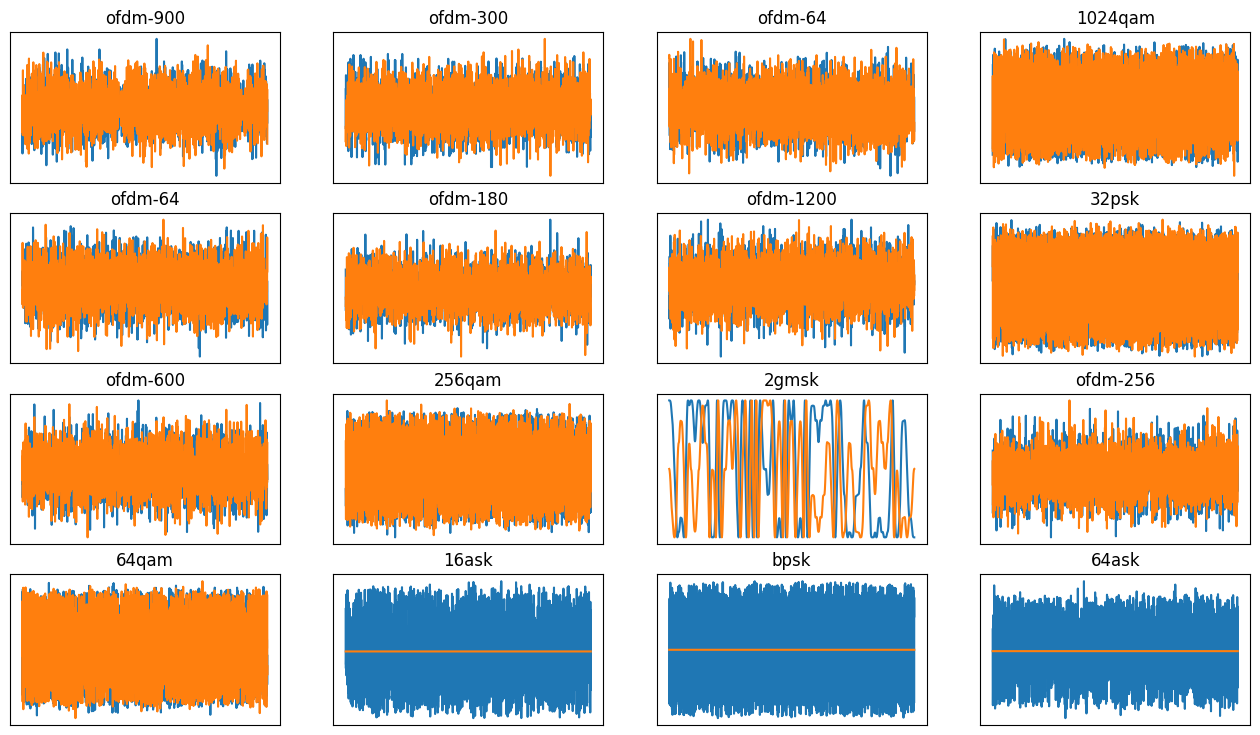

In [7]:
plot_dataset = DataWrapper(sig53)

data_loader = DataLoader(dataset=plot_dataset, batch_size=16, shuffle=True)


# Transform the plotting titles from the class index to the name
def target_idx_to_name(tensor: np.ndarray) -> List[str]:
    batch_size = tensor.shape[0]
    label = []
    for idx in range(batch_size):
        label.append(Sig53.convert_idx_to_name(int(tensor[idx])))
    return label


visualizer = IQVisualizer(
    data_loader=data_loader,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 9)
    plt.show()
    break

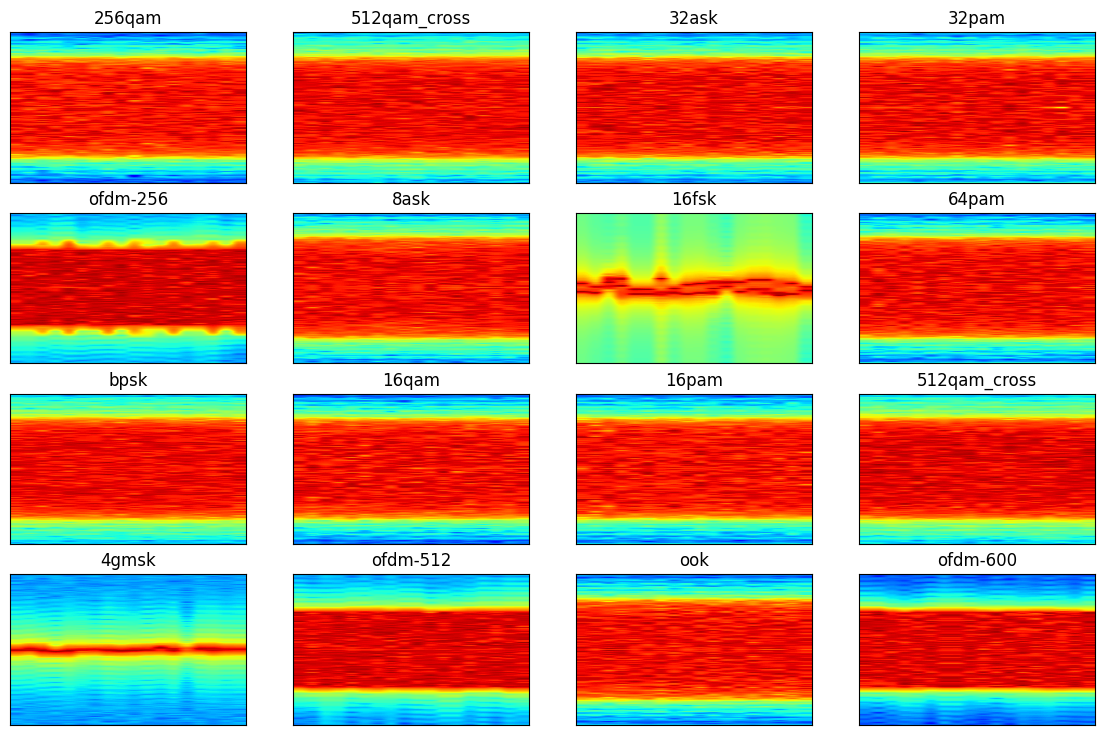

In [8]:
# Repeat but plot the spectrograms for a new random sampling of the data
visualizer = SpectrogramVisualizer(
    data_loader=data_loader,
    nfft=1024,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

----
### Analyze Dataset
The dataset can also be analyzed at the macro level for details such as the distribution of classes and SNR values. This exercise is performed below to show the nearly uniform distribution across each.

In [9]:
# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(Sig53._idx_to_name_dict.values())
}
all_snrs = []

for idx in tqdm(range(len(sig53))):
    data, (modulation, snr) = sig53[idx]
    class_counter_dict[Sig53.convert_idx_to_name(modulation)] += 1
    all_snrs.append(snr)

100%|██████████| 1060/1060 [00:00<00:00, 5918.94it/s]


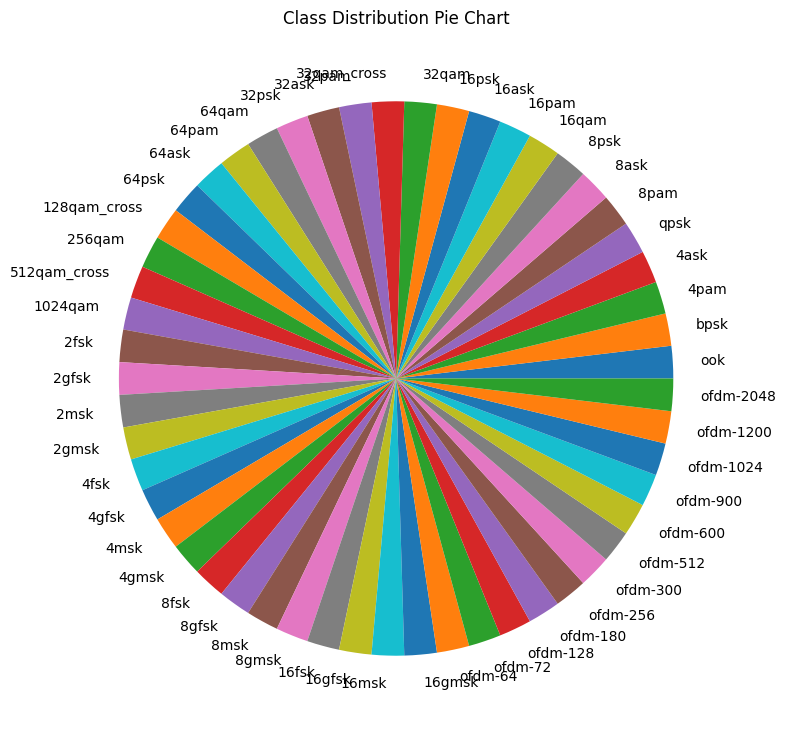

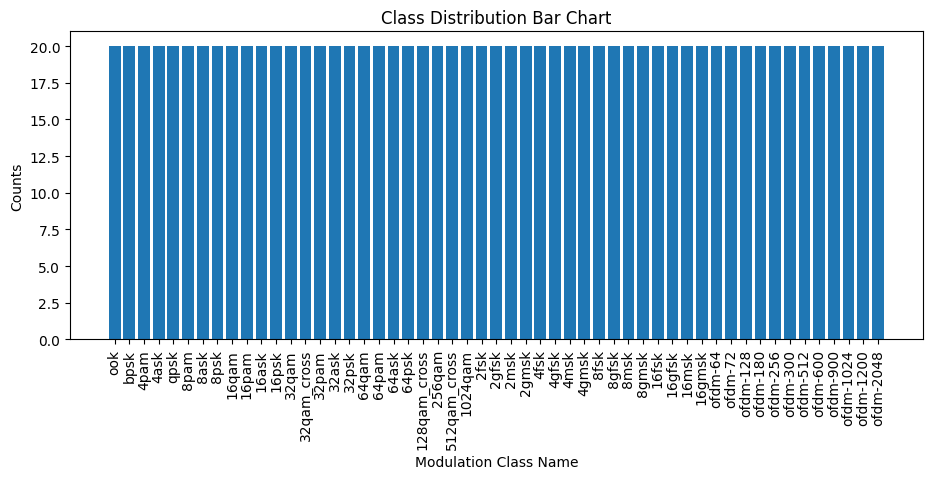

In [10]:
# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

plt.figure(figsize=(9, 9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")
plt.show()

plt.figure(figsize=(11, 4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")
plt.show()

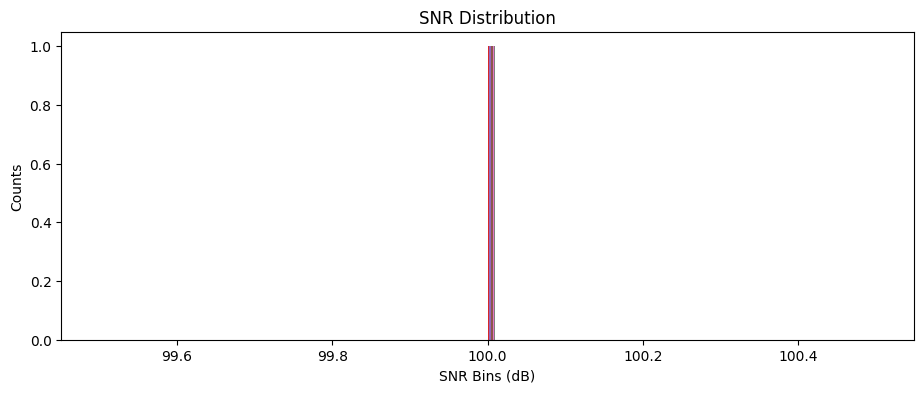

In [11]:
# Plot the distribution of SNR values
plt.figure(figsize=(11, 4))
plt.hist(x=all_snrs, bins=100)
plt.title("SNR Distribution")
plt.xlabel("SNR Bins (dB)")
plt.ylabel("Counts")
plt.show()